# Module 12 Lab - Distance Based Machine Learning

## Directions


The due dates for each are indicated in the Syllabus and the course calendar. If anything is unclear, please email EN685.648@gmail.com the official email for the course or ask questions in the Lab discussion area on Blackboard.

The Labs also present technical material that augments the lectures and "book".  You should read through the entire lab at the start of each module.

<div style="background: mistyrose; color: firebrick; border: 2px solid darkred; padding: 5px; margin: 10px;">
Please follow the directions and make sure you provide the requested output. Failure to do so may result in a lower grade even if the code is correct or even 0 points.
</div>

1. Show all work/steps/calculations. If it is easier to write it out by hand, do so and submit a scanned PDF in addition to this notebook. Otherwise, generate a Markdown cell for each answer.
2. You must submit to **two** places by the deadline:
    1. In the Lab section of the Course Module where you downloaded this file from, and
    2. In your Lab Discussion Group, in the forum for the appropriate Module.
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

We're getting to the point in the semester where you should be know the drill.

This module covered 3 basic problems: supervised learning (classification, regression), unsupervised learning (clustering) and recommenders (collaborative filtering based systems related to missing value imputation) using distance/similarity. We're only going to cover the first 2 in this lab.

You should definitely use [Scikit Learn](http://scikit-learn.org/stable/) and refer to the documentation for this assignment.

Remember to create a new random seed for each experiment (if needed) and save it.

**kNN Regression**

Use k-Nearest Neighbors *regression* for the insurance data set. Make sure you do the following:

1. Pick an appropriate evaluation metric.
2. Validation curves to find the best value of k.
3. Learning curves to see if we are high bias or high variance and suggest ways to improve the model.
4. 10 fold cross validation to estimate the mean metric and its credible interval.
5. Was this better than the best linear regression model you estimated in Lab 11? Use Bayesian statistical inference to generate and evaluate the posterior distribution of the difference of means.

First we have our imports followed by loading in the dataset.

In [1]:
import numpy as np
import random as py_random
import numpy.random as np_random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import sklearn

sns.set(style="whitegrid")

In [2]:
insurance = pd.read_csv("https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/insurance.csv", header=0)

I'll just make sure it loaded correctly. We should have 1338 values for each variable.

In [3]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Looks like we're good to go. Now we can start with the kNN and Scikit.

1. For our evaluation metric, we want to treat overestimates and underestimates the same while penalizing larger errors more than smaller errors. The loss function should then we the mean squared error, or root mean squared error (RMSE). If we create a Null model, we would use the mean to minimize our RMSE.

Since charges is our target variable, we can look quickly at our Null model.

In [4]:
insurance['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

Our mean is 13,270 and standard deviation is 12,110. We can also create error bounds with the std dev assuming a symmetrical distribution.

In [5]:
charges_mean = np.mean(insurance['charges'])
charges_std = np.std(insurance['charges'])

lower = charges_mean - 1.96 * charges_std
upper = charges_mean + 1.96 * charges_std

print(f'({lower}, {upper})')

(-10456.328286959502, 36997.17281724201)


Now this doesn't make sense because one this variable isn't actually symmetric and two charges cannot be negative. Since our focus is not on EDA and distributional models however I will move on.

2. Now let's use validation curves to find the best k value for k nearest neighbors. Most of this code is taken from the *Fundamentals DRAFT, Page 34*.

In [6]:
from sklearn.model_selection import validation_curve, ValidationCurveDisplay
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsRegressor

Before we get to the curves, we need to perform encodings for our categorical variables sex, smoker, and region, as we did with linear regression.

In [7]:
insurance = pd.concat([insurance, pd.get_dummies(insurance["sex"])], axis=1)
insurance = pd.concat([insurance, pd.get_dummies(insurance["smoker"], prefix="smoke")], axis=1)
insurance = pd.concat([insurance, pd.get_dummies(insurance['region'])], axis=1)

We can check all our variables now.

In [8]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges,female,male,smoke_no,smoke_yes,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,True,False,False,True,False,False,False,True
1,18,male,33.770,1,no,southeast,1725.55230,False,True,True,False,False,False,True,False
2,28,male,33.000,3,no,southeast,4449.46200,False,True,True,False,False,False,True,False
3,33,male,22.705,0,no,northwest,21984.47061,False,True,True,False,False,True,False,False
4,32,male,28.880,0,no,northwest,3866.85520,False,True,True,False,False,True,False,False


So let's create a regressors list and a target list to make working with the scikit learn tools easier.

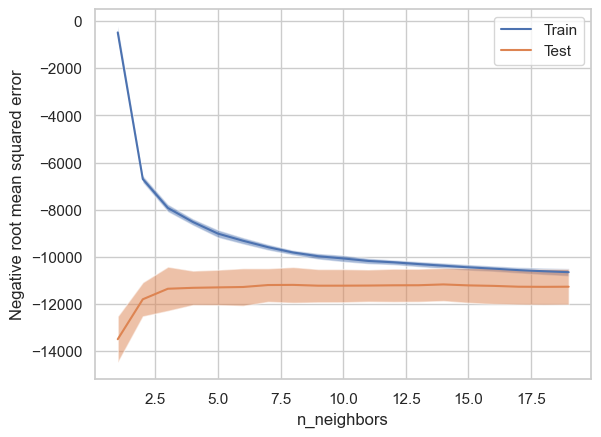

In [9]:
regressors = ['age', 'bmi', 'children', 'male', 'smoke_yes', 'northwest', 'southeast', 'southwest']
target = ['charges']

X = insurance[regressors]
y = insurance[target]

X, y = shuffle(X, y, random_state=10)
ValidationCurveDisplay.from_estimator(KNeighborsRegressor(), X, y, param_name='n_neighbors', param_range=list(range(1,20)), scoring='neg_root_mean_squared_error')


For low k values, the RMSE for the training data is only around maybe -500 and 'increases' as k increases. For the test data, low values of k have the RMSE around -14,000 and 'decreases' up to -11,000 as k increases. It looks like we get some sort of convergance for RMSE between the test data and training data around k = 10, although I might be inclined to say that k = 7.5 or even k=7 still might be good as well.

3. Now we can create learning curves to determine whether we are in high bias or high variance. From when we performed linear regression on this dataset (Module 11), we had a high bias situation for that model. Let's see if we get similar results here.

We'll use sklearn again, the way to plot learning curves are very similar to how we just looked at validation curves.

In [24]:
from sklearn.model_selection import LearningCurveDisplay, learning_curve

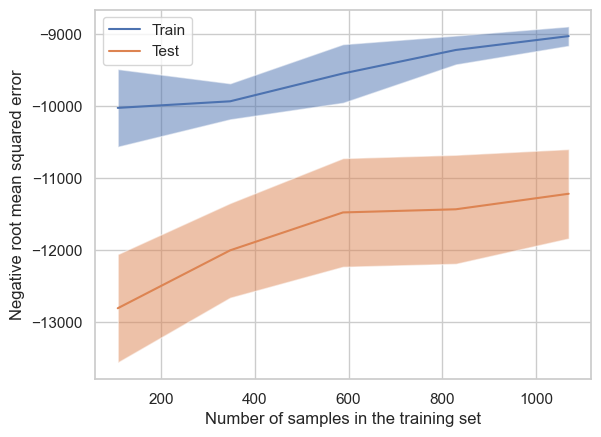

In [46]:

regressors = ['age', 'bmi', 'children', 'male', 'smoke_yes', 'northwest', 'southeast', 'southwest']
target = ['charges']

X = insurance[regressors]
y = insurance[target]

X, y = shuffle(X, y, random_state=10)
LearningCurveDisplay.from_estimator(KNeighborsRegressor(), X, y, scoring='neg_root_mean_squared_error')


So we see here that as we increase the amount of training data, the RMSE for both the training and test set increase. We don't see nice curves as we saw in linear regression, but what this tells us is that we are in a high bias situation and thus underfitting. One way we might improve the model is by getting more data.

4. Now we can use 10 cross-fold validation to estimate the mean metric and its credible interval.

Here are the imports

In [35]:
from sklearn.model_selection import train_test_split, cross_val_score

Let's make sure our data is in proper form.

In [36]:
x = insurance.loc[:, ['age', 'bmi', 'children', 'male', 'smoke_yes', 
                    'northwest', 'southeast', 'southwest']].values

y = insurance['charges'].values

We'll do 3 rounds of cross-fold validation just as we did for Lab 11. The main difference of course is using KNN algorithm instead of Linear Regression.

In [47]:
np.random.seed(83443)
model = KNeighborsRegressor()
mses = []
r2s = []


for i in range(0,3):
    # this shuffles the observations in the dataframe
    insurance = insurance.sample(frac=1).reset_index(drop=True)

    scores_mse = abs(cross_val_score(model, x, y, scoring='neg_root_mean_squared_error', cv=10))
    scores_r2 = abs(cross_val_score(model, x, y, scoring='r2', cv=10))

    mses.append(scores_mse)
    r2s.append(scores_r2)

Now we have our scores, we can concatenate to get all 30 into a single list for the mean squared error, r2 values, and sigmas.

In [49]:
mse_all = np.concatenate([mses[0], mses[1], mses[2]])
r2_all = np.concatenate([r2s[0], r2s[1], r2s[2]])
sigma_all = np.concatenate([np.sqrt(mses[0]), np.sqrt(mses[1]),np.sqrt(mses[2])])

pd.DataFrame(mse_all).describe()

,0
count,30.000000
mean,12896.551815
std,919.245309
min,11484.017054
25%,12015.964781
50%,13183.760928
75%,13684.428978
max,14055.559009


We see our results with the RMSE scoring we have a mean value of 12,896, and standard deviation of 919. We have a bit of a lower mean compared to the Null model of 13,270, and a much lower std dev compared to the Null's 12,110, roughly.

And now we can just use quantiles to get the credible intervals for the RMSE metric.

In [50]:
print('95% CI for sigma:', stats.mstats.mquantiles(mse_all, [0.025, 0.975]))

95% CI for sigma: [11484.01705442 14055.55900912]


We see a 95% probability that the mean falls between 11,484 and 14,055. We could make similar CI bounds for the $R^2$ and $\sigma$ as well but that's left as an exercise to the reader.